### [Anomaly Detection in Time Series](https://levelup.gitconnected.com/anomaly-detection-in-time-series-data-with-python-5a15089636db)

Anomaly detection identifies unusual patterns or outliers that deviate significantly from the expected behavior in a time series.

#### What is Anomaly Detection?

Anomalies in time series are classified into three types:

- **Point Anomalies** are individual values that are significantly different (e.g., a sudden spike in temperature).
- **Contextual Anomalies** are values that are unusual within a specific context, such as seasonality (e.g., higher electricity usage at night).
- **Collective Anomalies** are a sequence of values that deviate as a group (e.g., a long period of low readings).

The goal of anomaly detection is to identify and flag these irregularities automatically.

In [1]:
!pip install -q numpy pandas matplotlib
!pip install -q scikit-learn tensorflow keras

In [2]:
import os
## os.environ["KERAS_BACKEND"] = "jax"

import warnings
warnings.filterwarnings('ignore')

#### Algorithm: Isolation Forest
The *Isolation Forest* algorithm is an unsupervised anomaly detection method, originally introduced by **Amazon** as *Random Cut Forest*. It works by randomly partitioning the data into “trees” using random cuts to maximize entropy. Anomalies are values where a cut off tree (basically an isolated point) are very different than the overall values. RCF is fast, scalable, and effective for high-dimensional and time series data.

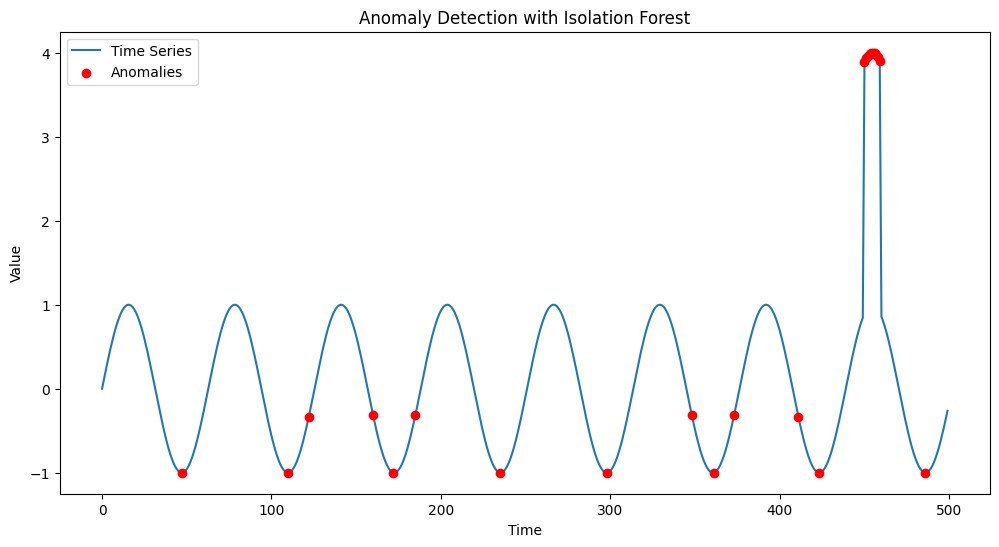

Number of anomalies detected: 24
Anomaly indices: [ 47 110 122 160 172 185 235 298 348 361 373 411 423 450 451 452 453 454
 455 456 457 458 459 486]


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest

# Simulated Time Series with Anomalies
np.random.seed(42)
normal_data = np.sin(np.linspace(0, 50, 500))  # Sine wave as normal data
anomaly_data = normal_data.copy()
anomaly_data[450:460] += 3  # Inject anomalies

# Reshape and Scale Data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(anomaly_data.reshape(-1, 1))

# Train Isolation Forest Model
iso_forest = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
iso_forest.fit(scaled_data)

# Compute Anomaly Scores
scores = iso_forest.decision_function(scaled_data)
scores = -scores  # Invert scores so that higher values indicate more anomalous points

# Identify Anomalies: Points with Low Decision Function Values
threshold = np.percentile(scores, 95)  # Top 5% as anomalies
anomalies = np.where(scores > threshold)[0]

# Plot Results
plt.figure(figsize=(12, 6))
plt.plot(anomaly_data, label="Time Series")
plt.scatter(anomalies, anomaly_data[anomalies], color='red', label="Anomalies", zorder=5)
plt.title("Anomaly Detection with Isolation Forest")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
# plt.savefig('anomaly_detection_isolation_forest.png')
plt.show()

print(f"Number of anomalies detected: {len(anomalies)}")
print(f"Anomaly indices: {anomalies}")

#### Autoencoders for Anomaly Detection
Autoencoders are deep learning models trained to reconstruct input data. If the input contains anomalies, the reconstruction error will be higher for these points because the model focuses on learning the “normal” patterns of the data.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed
from keras.callbacks import EarlyStopping

def generate_data(n_points=1000, anomaly_start=700, anomaly_end=710):
    time = np.arange(n_points)
    data = np.sin(0.02 * time) + np.random.normal(0, 0.1, n_points)
    data[anomaly_start:anomaly_end] += 3  # Inject anomalies
    return data

def prepare_data(data, window_size=20):
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data.reshape(-1, 1))
    X = np.array([data_scaled[i:i+window_size] for i in range(len(data_scaled) - window_size)])
    return X, scaler

def create_model(window_size):
    model = Sequential([
        LSTM(32, activation='relu', input_shape=(window_size, 1), return_sequences=True),
        LSTM(16, activation='relu', return_sequences=False),
        RepeatVector(window_size),
        LSTM(16, activation='relu', return_sequences=True),
        LSTM(32, activation='relu', return_sequences=True),
        TimeDistributed(Dense(1))
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def detect_anomalies(reconstruction_error, threshold=3):
    mean = np.mean(reconstruction_error)
    std = np.std(reconstruction_error)
    return reconstruction_error > mean + threshold * std

def plot_results(data, reconstruction_error, threshold=3, window_size=20):
    plt.figure(figsize=(12, 6))
    
    # Plot the original data
    plt.plot(data[window_size:], label="Time Series")
    
    # Detect anomalies
    mean = np.mean(reconstruction_error)
    std = np.std(reconstruction_error)
    anomalies = reconstruction_error > mean + threshold * std
    
    # Plot anomalies
    anomaly_indices = np.where(anomalies)[0] + window_size
    plt.scatter(anomaly_indices, data[anomaly_indices], color='red', label="Anomalies")
    
    plt.title("Anomaly Detection with LSTM Autoencoder")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend()
    ## plt.savefig('lstm_anomaly_detection.jpg')
    plt.show()
    
    return anomalies

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 0.0718 - val_loss: 0.0194
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0254 - val_loss: 0.0111
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0169 - val_loss: 0.0041
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0114 - val_loss: 0.0018
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0073 - val_loss: 0.0014
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0060 - val_loss: 0.0012
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0055 - val_loss: 0.0011
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0047 - val_loss: 9.6068e-04
Epoch 9/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0033 - val_loss: 8.2585e-04
Epoch 10/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0037 - val_loss: 7.0890e-04
Epoch 11/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0038 - val_loss: 8.3594e-04
Epoch 12/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/

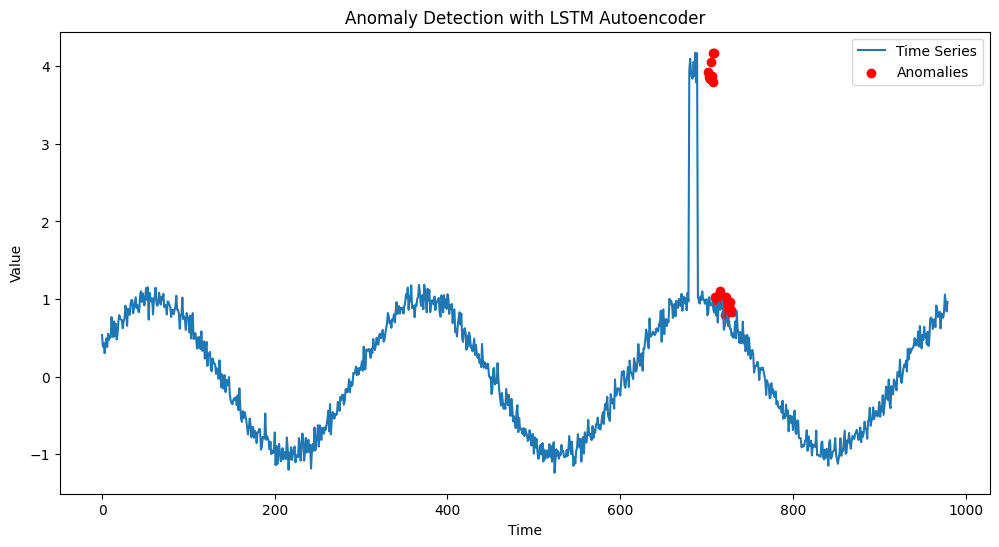

Number of anomalies detected: 28


In [5]:
# Generate data
data = generate_data()

# Prepare data
X, scaler = prepare_data(data)

# Create and train model
model = create_model(window_size=20)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model.fit(X, X, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping], verbose=1)

# Predict and calculate reconstruction error
X_pred = model.predict(X)
reconstruction_error = np.mean(np.abs(X - X_pred), axis=(1, 2))

# Detect anomalies
anomalies = detect_anomalies(reconstruction_error)

# Plot results
plot_results(data, anomalies, window_size=20)

print(f"Number of anomalies detected: {np.sum(anomalies)}")

The LSTM autoencoder learns to reconstruct “normal” time series data. High reconstruction errors correspond to anomalies.

- RCF is best for simple point anomalies where interpretability and speed are priorities.

- Autoencoders are best for detecting complex anomalies in sequential data, such as collective and contextual outliers.

Anomaly detection is an automated approach for identifying unusual behaviors (read weird values) in time series data. Random Cut Forest and Autoencoders are two approaches to effectively detect both simple and complex outliers and these are good tools for real-world applications like predictive maintenance, fraud detection, and system monitoring.